# Replicating opt-SNE

### Preliminaries

In [3]:
%matplotlib inline

# imports 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import flowkit as fk 
from openTSNE import TSNE
import FlowCal

In [4]:
file_path = 'data/flow18_annotated.fcs'
flow_data = FlowCal.io.FCSData(file_path)
print("FCS file loaded successfully!")

FCS file loaded successfully!


In [5]:
# Pre-processing data 

sample = fk.Sample(flow_data, sample_id='flow18', channel_labels=('Parameter_1', 'Parameter_10', 'Parameter_11', 'Parameter_12', 'Parameter_13', 'Parameter_14', 'Parameter_15', 'Parameter_16', 'Parameter_17', 'Parameter_18', 'Parameter_19', 'Parameter_2', 'Parameter_20', 'Parameter_21', 'Parameter_22', 'Parameter_23', 'Parameter_24', 'Parameter_3', 'Parameter_4', 'Parameter_5', 'Parameter_6', 'Parameter_7', 'Parameter_8', 'Parameter_9', 'SampleID', 'class'))
df_events = sample.as_dataframe(source="raw")

# only use selected columns 
selected_columns = [
    'Parameter_8', 'Parameter_9', 'Parameter_10', 'Parameter_11', 'Parameter_12', 
    'Parameter_13', 'Parameter_15', 'Parameter_18', 'Parameter_20', 
    'Parameter_21', 'Parameter_23', 'class'
]

df_filtered = df_events[selected_columns]

fraction_used = 1.0 

# sample from dataset 
data_sample = df_filtered.sample(frac=fraction_used).reset_index(drop=True)

# get features and labels 
features = data_sample.drop(columns=['class'])  # All columns except 'class'
labels = data_sample['class']  # Only the 'class' column

/var/folders/4d/3496lhrx28308spwb6q8gb800000gn/T/ipykernel_44445/4018012947.py:21: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  features = data_sample.drop(columns=['class'])  # All columns except 'class'


In [9]:
# KLD Tracker 
from openTSNE import callbacks
# Define a custom callback to record KL divergence
class KLDTracker(callbacks.Callback):
    def __init__(self, record_every=10):
        self.kl_divergences = []
        self.record_every = record_every

    def __call__(self, iteration, error, embedding):
        # Record KL divergence at the specified interval
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))
        return False 

In [ ]:
# plot KLD function 
def plot_KLD(): 
    return False 

## Section 1: Number of Iterations

In [7]:
# step 1: define affinities 
import openTSNE 
affinites = openTSNE.affinity.PerplexityBasedNN(
    features.to_numpy(),
    n_jobs=-1,
    random_state=12,
    verbose=True
    )

# step 2: define initial embedding 
init = openTSNE.initialization.pca(features.to_numpy(), random_state=12)

# step 3: construct TSNEEmbedding object 
from openTSNE import TSNEEmbedding
embedding = TSNEEmbedding(
    init, 
    affinites, 
    verbose=True
)

===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 776.80 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 157.09 seconds


#### total iter: 1000, EE stop: 250

In [10]:
## step 4: EE phase 
kld_tracker_EE = KLDTracker(record_every=10)
EE250_embedding = embedding.optimize(n_iter=250, exaggeration=12, callbacks= kld_tracker_EE, callbacks_every_iters=10, verbose=True)

===> Running optimization with exaggeration=12.00, lr=83335.08 for 250 iterations...
Iteration   50, KL divergence 8.2788, 50 iterations in 321.1542 sec
Iteration  100, KL divergence 8.0638, 50 iterations in 254.5790 sec
Iteration  150, KL divergence 7.9822, 50 iterations in 239.5090 sec
Iteration  200, KL divergence 7.9436, 50 iterations in 242.0325 sec
Iteration  250, KL divergence 7.9204, 50 iterations in 237.3755 sec
   --> Time elapsed: 1294.66 seconds


In [13]:
# Convert to DataFrame 
embedding_df = pd.DataFrame(EE250_embedding, columns=['x', 'y'])
embedding_df['label'] = labels
# Save to CSV
embedding_df.to_csv('flow18_EE250.csv', index=False)

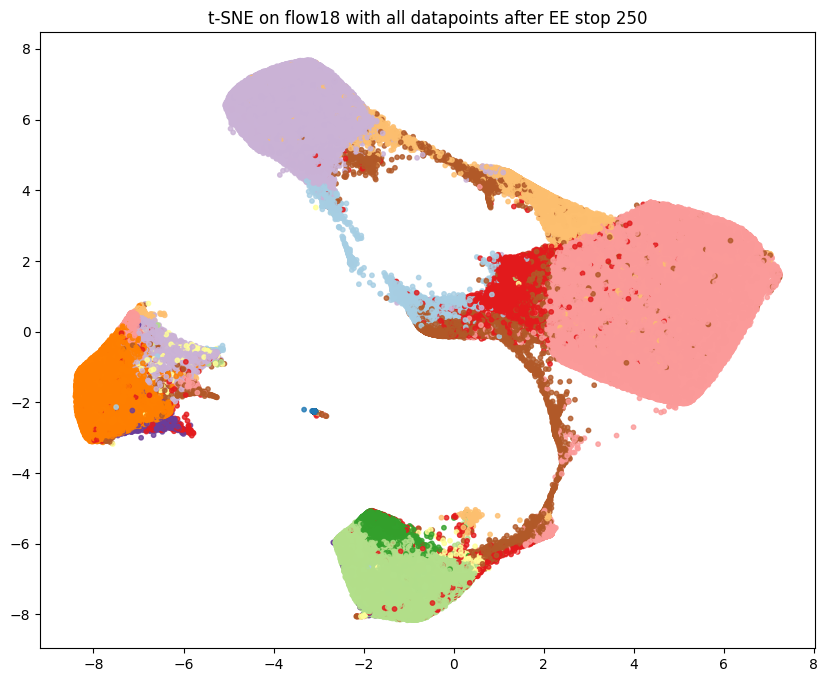

In [12]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(EE250_embedding[:, 0], EE250_embedding[:, 1], c=labels, cmap=plt.colormaps.get_cmap('Paired'), s=10, alpha=0.8)
plt.title("t-SNE on flow18 with all datapoints after EE stop 250")
plt.show()

In [14]:
# step 5: embedding phase of t-SNE 
kld_tracker_embed = KLDTracker(record_every=10)

final_embedding_short = EE250_embedding.optimize(n_iter=750, callbacks=kld_tracker_embed, callbacks_every_iters=10, verbose=True)

===> Running optimization with exaggeration=1.00, lr=1000021.00 for 750 iterations...
Iteration   50, KL divergence 6.0081, 50 iterations in 242.8811 sec
Iteration  100, KL divergence 5.6874, 50 iterations in 243.2993 sec
Iteration  150, KL divergence 5.5150, 50 iterations in 226.5574 sec
Iteration  200, KL divergence 5.4003, 50 iterations in 231.2904 sec
Iteration  250, KL divergence 5.3151, 50 iterations in 241.8895 sec
Iteration  300, KL divergence 5.2478, 50 iterations in 236.9892 sec
Iteration  350, KL divergence 5.1925, 50 iterations in 243.5775 sec
Iteration  400, KL divergence 5.1457, 50 iterations in 245.5317 sec
Iteration  450, KL divergence 5.1052, 50 iterations in 247.4343 sec
Iteration  500, KL divergence 5.0696, 50 iterations in 252.1652 sec
Iteration  550, KL divergence 5.0379, 50 iterations in 250.7833 sec
Iteration  600, KL divergence 5.0093, 50 iterations in 261.4573 sec
Iteration  650, KL divergence 4.9834, 50 iterations in 262.5209 sec
Iteration  700, KL divergence 

In [15]:
# Convert to DataFrame 
embedding_df = pd.DataFrame(final_embedding_short, columns=['x', 'y'])
embedding_df['label'] = labels
# Save to CSV
embedding_df.to_csv('flow18_EE250_1000iter.csv', index=False)

missing so far: KLD plot (TODO)

<Figure size 800x800 with 0 Axes>

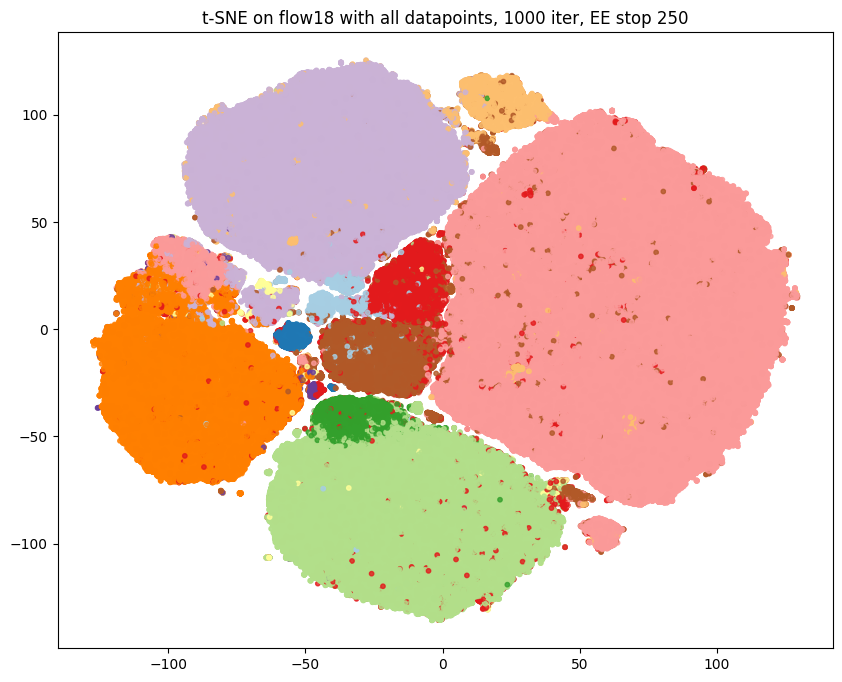

In [16]:
fig = plt.figure(figsize=(8,8))
plt.figure(figsize=(10, 8))
scatter = plt.scatter(final_embedding_short[:, 0], final_embedding_short[:, 1], c=labels, cmap=plt.colormaps.get_cmap('Paired'), s=10, alpha=0.8)
plt.title("t-SNE on flow18 with all datapoints, 1000 iter, EE stop 250")
plt.show()

#### total iter: 3000, EE stop: 750

In [17]:
## step 4: EE phase 
kld_tracker_EE2 = KLDTracker(record_every=10)
EE750_embedding = embedding.optimize(n_iter=750, exaggeration=12, callbacks= kld_tracker_EE2, callbacks_every_iters=10, verbose=True)

===> Running optimization with exaggeration=12.00, lr=83335.08 for 750 iterations...
Iteration   50, KL divergence 8.2788, 50 iterations in 237.8412 sec
Iteration  100, KL divergence 8.0638, 50 iterations in 231.3160 sec
Iteration  150, KL divergence 7.9822, 50 iterations in 225.4907 sec
Iteration  200, KL divergence 7.9436, 50 iterations in 219.4222 sec
Iteration  250, KL divergence 7.9204, 50 iterations in 225.1207 sec
Iteration  300, KL divergence 7.9044, 50 iterations in 222.5567 sec
Iteration  350, KL divergence 7.8926, 50 iterations in 244.2278 sec
Iteration  400, KL divergence 7.8834, 50 iterations in 220.6952 sec
Iteration  450, KL divergence 7.8760, 50 iterations in 227.3748 sec
Iteration  500, KL divergence 7.8699, 50 iterations in 219.7219 sec
Iteration  550, KL divergence 7.8648, 50 iterations in 232.3507 sec
Iteration  600, KL divergence 7.8612, 50 iterations in 218.5580 sec
Iteration  650, KL divergence 7.8574, 50 iterations in 237.8097 sec
Iteration  700, KL divergence 7

In [18]:
# Convert to DataFrame 
embedding_df = pd.DataFrame(EE750_embedding, columns=['x', 'y'])
embedding_df['label'] = labels
# Save to CSV
embedding_df.to_csv('flow18_EE750.csv', index=False)

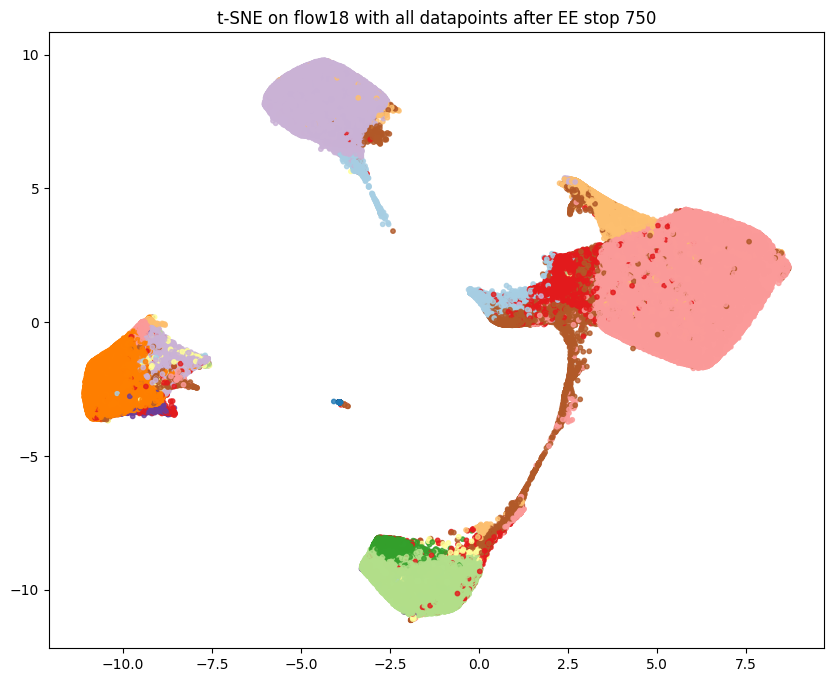

In [19]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(EE750_embedding[:, 0], EE750_embedding[:, 1], c=labels, cmap=plt.colormaps.get_cmap('Paired'), s=10, alpha=0.8)
plt.title("t-SNE on flow18 with all datapoints after EE stop 750")
plt.show()

In [ ]:
# step 5: embedding phase of t-SNE 
kld_tracker_embed2 = KLDTracker(record_every=10)

final_embedding_long = EE750_embedding.optimize(n_iter=2250, callbacks=kld_tracker_embed2, callbacks_every_iters=10, verbose=True)

===> Running optimization with exaggeration=1.00, lr=1000021.00 for 2250 iterations...
Iteration   50, KL divergence 6.0028, 50 iterations in 240.1168 sec
Iteration  100, KL divergence 5.6883, 50 iterations in 231.4797 sec
Iteration  150, KL divergence 5.5171, 50 iterations in 231.3887 sec
Iteration  200, KL divergence 5.4028, 50 iterations in 243.8033 sec
Iteration  250, KL divergence 5.3179, 50 iterations in 242.6175 sec
Iteration  300, KL divergence 5.2508, 50 iterations in 245.8871 sec
Iteration  350, KL divergence 5.1956, 50 iterations in 891.2903 sec
Iteration  400, KL divergence 5.1489, 50 iterations in 250.1543 sec
Iteration  450, KL divergence 5.1085, 50 iterations in 263.4240 sec
Iteration  500, KL divergence 5.0730, 50 iterations in 254.2741 sec


In [ ]:
fig = plt.figure(figsize=(8,8))
plt.figure(figsize=(10, 8))
scatter = plt.scatter(final_embedding_long[:, 0], final_embedding_long[:, 1], c=labels, cmap=plt.colormaps.get_cmap('Paired'), s=10, alpha=0.8)
plt.title("t-SNE on flow18 with all datapoints, 3000 iter, EE stop 750")
plt.show()